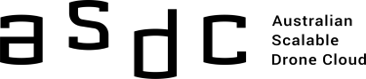

## <center>Structural Geology Use Case</center>


Fracture detection with Complex Shearlet Transform based on 
https://github.com/rahulprabhakaran/Automatic-Fracture-Detection-Code

Using the Python port of the Matlab Toolbox Complex Shearlet-Based Ridge and Edge Measurement by Rafael Reisenhofer: 

https://github.com/rgcda/PyCoShREM

In [1]:
import sys
import os
sys.path.append('py_modules')
from processing import *
from tools import *

# Select Image
## Data
### rgb (UAV)
Orthofototile (286x287px) derived from:\
https://research.tudelft.nl/en/datasets/fracture-network-patterns-from-the-parmelan-anticline-france-2

### rgb_2
Example image (875x875px)from\
https://github.com/rahulprabhakaran/Automatic-Fracture-Detection-Code/blob/master/Examples/Bingie_Bingie/Bingie_Bingie_area2.tif.

### rgb_3 (UAV)
Orthofototile (647x647px) derived from: Weismüller, C., Reicherter, K., Passchier, M. and Urai, J., 2020. The fracture network in the Lilstock pavement, Bristol Channel, UK: digital elevation models and orthorectified mosaics created from unmanned aerial vehicle imagery (No. RWTH-2020-06903). Lehr-und Forschungsgebiet Neotektonik und Georisiken.
10m_models
https://publications.rwth-aachen.de/record/793416?ln=en
[10_1_Ortho.tif]

### dem (UAV)
DEMtile (647x647px) derived from: Weismüller, C., Reicherter, K., Passchier, M. and Urai, J., 2020. The fracture network in the Lilstock pavement, Bristol Channel, UK: digital elevation models and orthorectified mosaics created from unmanned aerial vehicle imagery (No. RWTH-2020-06903). Lehr-und Forschungsgebiet Neotektonik und Georisiken.
10m_models
https://publications.rwth-aachen.de/record/793416?ln=en
[10_1_DEM.tif]

### mag
Tile of total magetoic intesity (reduced to pole) data obtained from:
https://www.energymining.sa.gov.au/minerals/geoscience/gcas_bulkmail/gcas_24

## Image operations

### Histogram equalization
Histogram equalisation to enhance the contrast.
### Gaussian blur
Gaussian blur with a 5x5 kernel.
### Sharpen
Sharpen image by applying a kernel of the form:\
-1 -1 -1\
-1  9 -1\
-1 -1 -1
### Edge
Convolution fiter with Mexican hat of the form:\
 0  0 -1  0  0\
 0 -1 -2 -1  0\
-1 -2 16 -2 -1\
 0  0 -1  0  0
### Sobel
Compute the mean of the horizontal and vertical image gradients.
### Invert
Invert the image.

In [2]:
Tools.SelectFile(Tools)
Tools.SelectEnhancement(Tools)

Dropdown(description='Imagetype:', options=('rgb', 'rgb_2', 'rgb_3', 'dem', 'mag'), value='rgb')

image size:  (286, 287)
selected 1  images


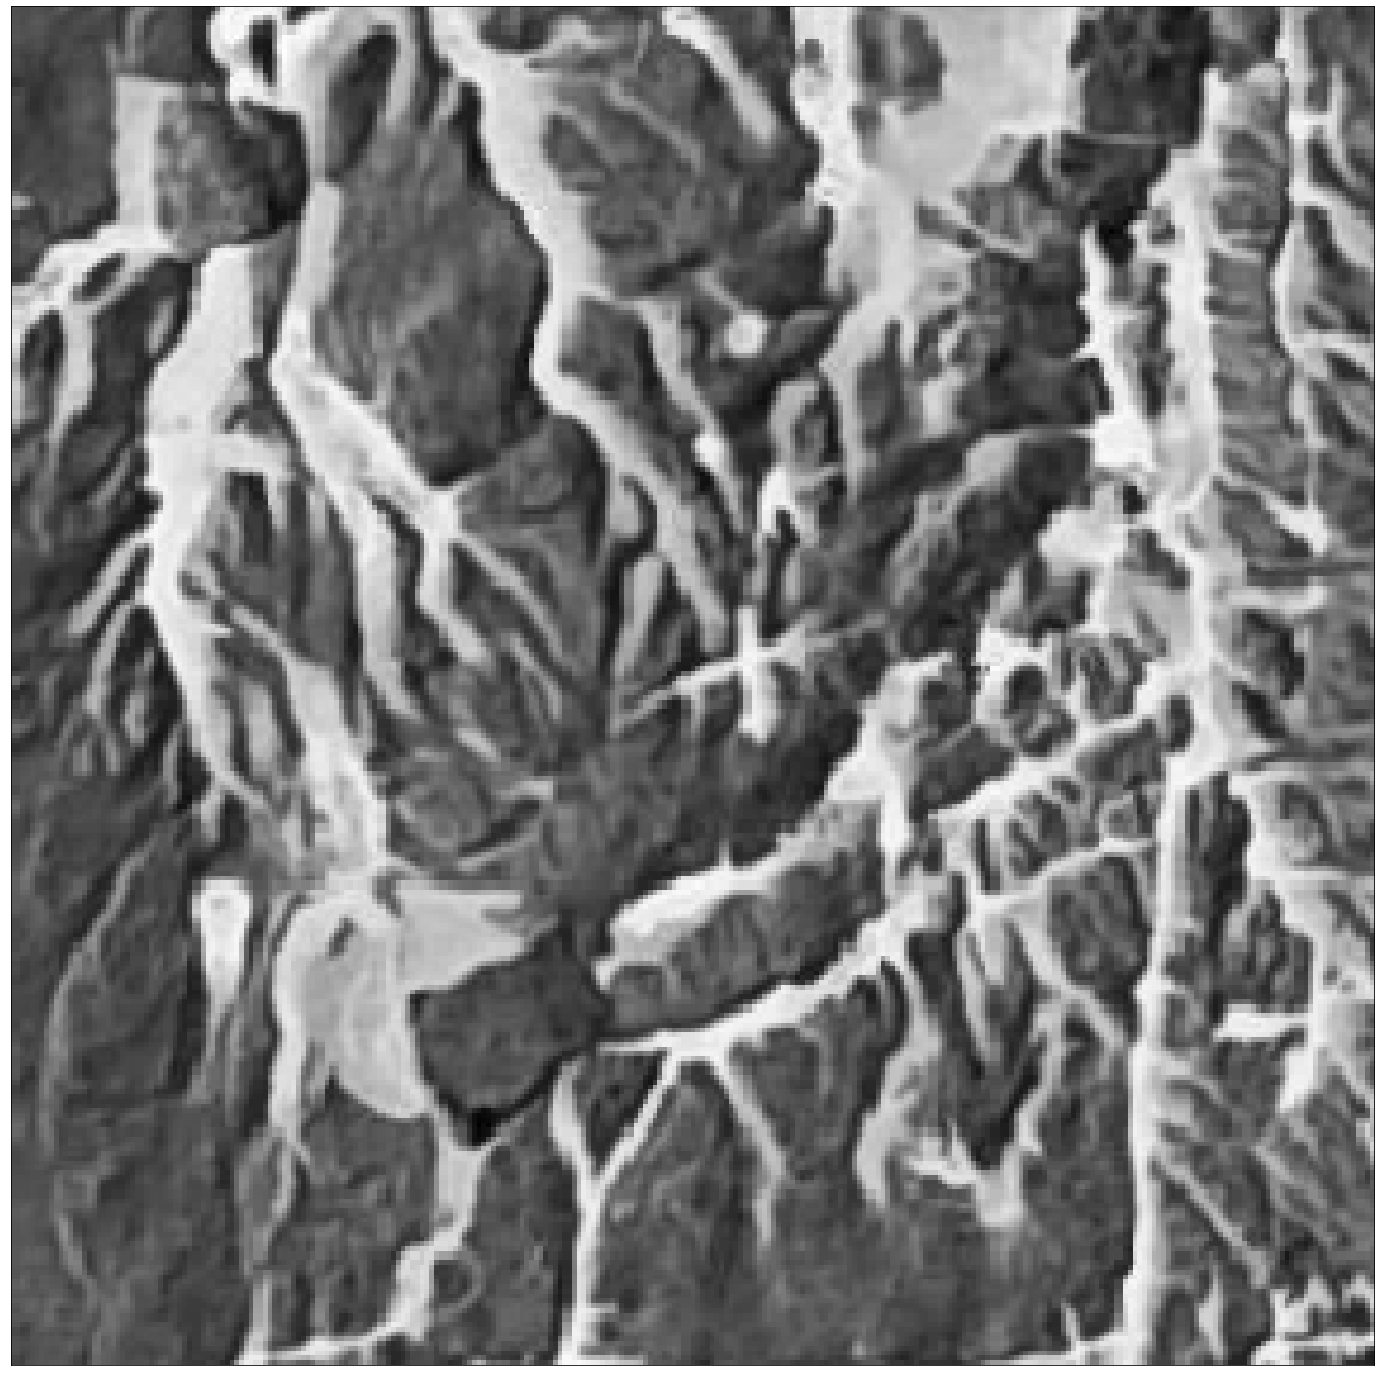

In [3]:
img_list = ReadImage(Tools.FILE, 
                     Tools.HISTEQ, 
                     Tools.GAUSBL, 
                     Tools.SHARPE, 
                     Tools.EDGE, 
                     Tools.SOBEL, 
                     Tools.INVERT)
Tools.ShowImage(img_list)   
i_size = ImgSizes(img_list)

# Select System Parameters
Taken from 'The CoShREM Toolbox Parameter Guide' by Rafael Reisenhofer.\
http://www.math.uni-bremen.de/cda/software/CoShREM_Parameter_Guide.pdf

### waveletEffSupp

Length of the effective support in pixels of the Mexican hat wavelet ψ used in the construction the generating shearlet ψgen(x, y) = ψ(x)φ(y), where φ is a Gaussian. The effective support is the interval on which the values of ψ significantly differ from 0. It is, however, not a strictly defined property. A good choice for this parameter is often 1/8 of the image width. If the edges/ridges in the processed image are visible on a large scale, this value should be large relative to the width and height of the processed image.

### gaussianEffSupp
Length of the effective support in pixels of the Gaussian φ used in the construction of the generating shearlet ψgen(x, y) = ψ(x)φ(y), where ψ is a Mexican hat wavelet. Typically, this value is chosen to be roughly the half of waveletEffSupp. However, if the edges/ridges in the processed image consist of smooth curves, it can be chosen larger.

### scalesPerOctave
Determines the number of intermediate scales for each octave. If scalesPerOctave is set to n, for each orientation, there will be n differently scaled shearlets within one octave.

### shearLevel (orientations)
Determines the number of differently oriented shearlets on each scale. If shearLevel is set to n, there will be 2n + 2 differently sheared shearlets on each scale, completing a 180◦ semi-circle.

### alpha (orientations)
This parameter can take any value between 0 and 1 and governs the degree of anisotropy introduced via scaling. Roughly speaking, it determines how much the Gaussian is squeezed relative to the wavelet, when scaling the generating shearlet. Formally, the n-th octave is defined by ψn(x, y) = ψgen(2nx, 2αny). For alpha = 0, the degree of anisotropy is maximized while for alpha = 1, both directions are treated the same.

### octaves
The number of octaves spanned by the shearlet system. When scales- PerOctave is greater than 1, this parameter can also take non-integer values.

In [4]:
Tools.SystemCombinations(Tools)

In [5]:
systems = GenerateSystems(i_size, 
                          SplitInput(Tools.WAVEEF, False),
                          SplitInput(Tools.GAUSEF, False),
                          SplitInput(Tools.SCALES, True),
                          SplitInput(Tools.SHEARL, True),
                          SplitInput(Tools.ALPHA, False),
                          SplitInput(Tools.OCTAVE, False),
                          Tools.RIDGES)                        

generating  9  systems.
 done in  4.337721824645996 s


# Detection Parameters

### minContrast
Specifies the minimal contrast for an edge/ridge to be detected.

### offset
This parameter defines a scaling offset between the even- and odd- symmetric shearlets measured in octaves. If offset = x, the first even-symmetric shearlet used for the computation of the complex shearlet-based edge measure is already x octaves above the first odd- symmetric shearlet considered. In the case of the ridge measure, the converse is true.

### scalesUsedForPivotSearch
This parameter defines which scales of the shearlet system are considered for determining the orientation for which the complex shearlet-based edge/ridge measure is computed at a specific loca- tion. It can take the values ’all’, ’highest’, ’lowest’ and any subset B ⊂ {1, . . . , scalesPerOctave·octaves}.

In [6]:
Tools.DetectionCombinations(Tools, Tools.RIDGES)

In [7]:
features = DetectFeatures(img_list, 
                          i_size,
                          systems, 
                          SplitInput(Tools.MINCON, False),
                          SplitInput(Tools.OFFSET, False),
                          Tools.PIVOTS, 
                          Tools.NEGATI, 
                          Tools.POSITV, 
                          Tools.RIDGES)

detecting features with  9  systems.
4  detection combinations.
 done in  63.69996452331543 s


In [ ]:
Tools.ShowOverlay(img_list, features)

# Clean feature ensemble

### min pixel value
The minimum pixel value in teh normalized feature ensemble. Pixel below this threshold will be exluded.

### kernel size
The size of the kernel used for morhological closing (Dilation followed by Erosion). 

### contrast
The contrast enahncemnt perfomed on teh feature image.

### connectivity
Minimum connectivity of pixel clusters.

### min cluster size
The minimum size of pixel cluster to keep in teh image. Clusters below this threshold will be excluded.

In [ ]:
Tools.Enhancement(Tools)

In [ ]:
enh_img_list = EnhanceEnsemble(features,  
                            Tools.THRESH, 
                            Tools.KSIZE, 
                            Tools.CONTRA,
                            Tools.CONNE,
                            Tools.MINSI)
Tools.ShowCompare(features, enh_img_list)